# Random forest with fingerprints

In order to benchmark our proposed models we decided to first construct a random forest baseline model that is trained on molecular fingerprints.

In [1]:
!pip install shap rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.3 MB/s eta 0:00:00


In [2]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from rdkit import Chem
from rdkit.Chem import Draw , MACCSkeys
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from IPython.display import Image
from IPython.display import display, HTML
from PIL import Image, ImageDraw, ImageFont

In [3]:
df = pd.read_csv('data_cleaned.csv')

## Check SMILES

In order to train the random forest we need to compute the molecular fingerprint of each DESs. We will be using rdkit for this, but we need first to get the SMILES for each HBA and HBD. Let's check the SMILES that we have collected and compare them to Fig. 1 and Fig. 2 of the original paper to make sure that the same structures are taken into account.

In [4]:
df['HBA name'].unique()

array(['[ACh]Cl', 'Thymol', '[Ch]Cl', '[TOA]Cl', '[TOA]Br', '[BTEA]Cl',
       '[BTMA]Cl', '[TBA]Br', '[TBA]Cl', '[TEA]Cl', '[TMA]Cl', '[TEMA]Cl',
       '[Gua]Cl', '[TOMA]Cl', '[TOMA]Br', '[BHDE]Cl', '[TEA]Br',
       'Menthol', '[MTPP]Br', '[DEA]Cl', 'Betain', '[TPA]Cl', '[TBP]Br',
       '[ATPP]Br'], dtype=object)

In [5]:
df_hba = pd.read_csv('HBA_smiles.csv')
df_hba.head()

,Name,Short,SMILES
0,Acetylcholine chloride,[ACh]Cl,CC(=O)OCC[N+](C)(C)C.[Cl-]
1,Thymol,Thymol,Cc1ccc(C(C)C)c(O)c1
2,Choline chloride,[Ch]Cl,C[N+](C)(C)CCO.[Cl-]
3,Tetraoctylammonium chloride,[TOA]Cl,CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC.[Cl-]
4,Tetraoctylammonium bromide,[TOA]Br,CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC.[Br-]


In [6]:
def smiles_to_grid_image(smiles_list, names_list, columns=4, font_size=16):
    """
    Converts a list of SMILES strings to a grid image of their structures with names.

    Args:
    - smiles_list (list of str): List of SMILES strings.
    - names_list (list of str): List of molecule names.
    - columns (int): Number of columns in the output grid.
    - font_size (int): Font size for molecule names.

    Returns:
    - PIL.Image: Image of molecules with names in a grid.
    """

    if len(smiles_list) != len(names_list):
        raise ValueError("The number of SMILES strings should match the number of names provided.")

    # Convert SMILES to RDKit Mol objects
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]

    # Generate individual molecule images
    imgs = [Draw.MolToImage(mol) for mol in mols]

    # Create a font object for drawing text
    font = ImageFont.load_default()

    # Get image dimensions
    img_width, img_height = imgs[0].size

    # Adjust the cell height to include text
    cell_height = img_height + font_size

    # Calculate the number of rows for the given number of columns
    rows = (len(imgs) // columns) + (1 if len(imgs) % columns else 0)

    # Create a blank white image to paste the molecule images onto
    grid_img = Image.new('RGB', (img_width * columns, cell_height * rows), 'white')
    draw = ImageDraw.Draw(grid_img)

    for i, (img, name) in enumerate(zip(imgs, names_list)):
        x = i % columns * img_width
        y = i // columns * cell_height

        # Paste the molecule image
        grid_img.paste(img, (x, y))

        # Draw the molecule name below the image
        text_x = x + (img_width - draw.textlength(name, font)) // 2  # Centered text
        text_y = y + img_height
        draw.text((text_x, text_y), name, font=font, fill="black")

    return grid_img

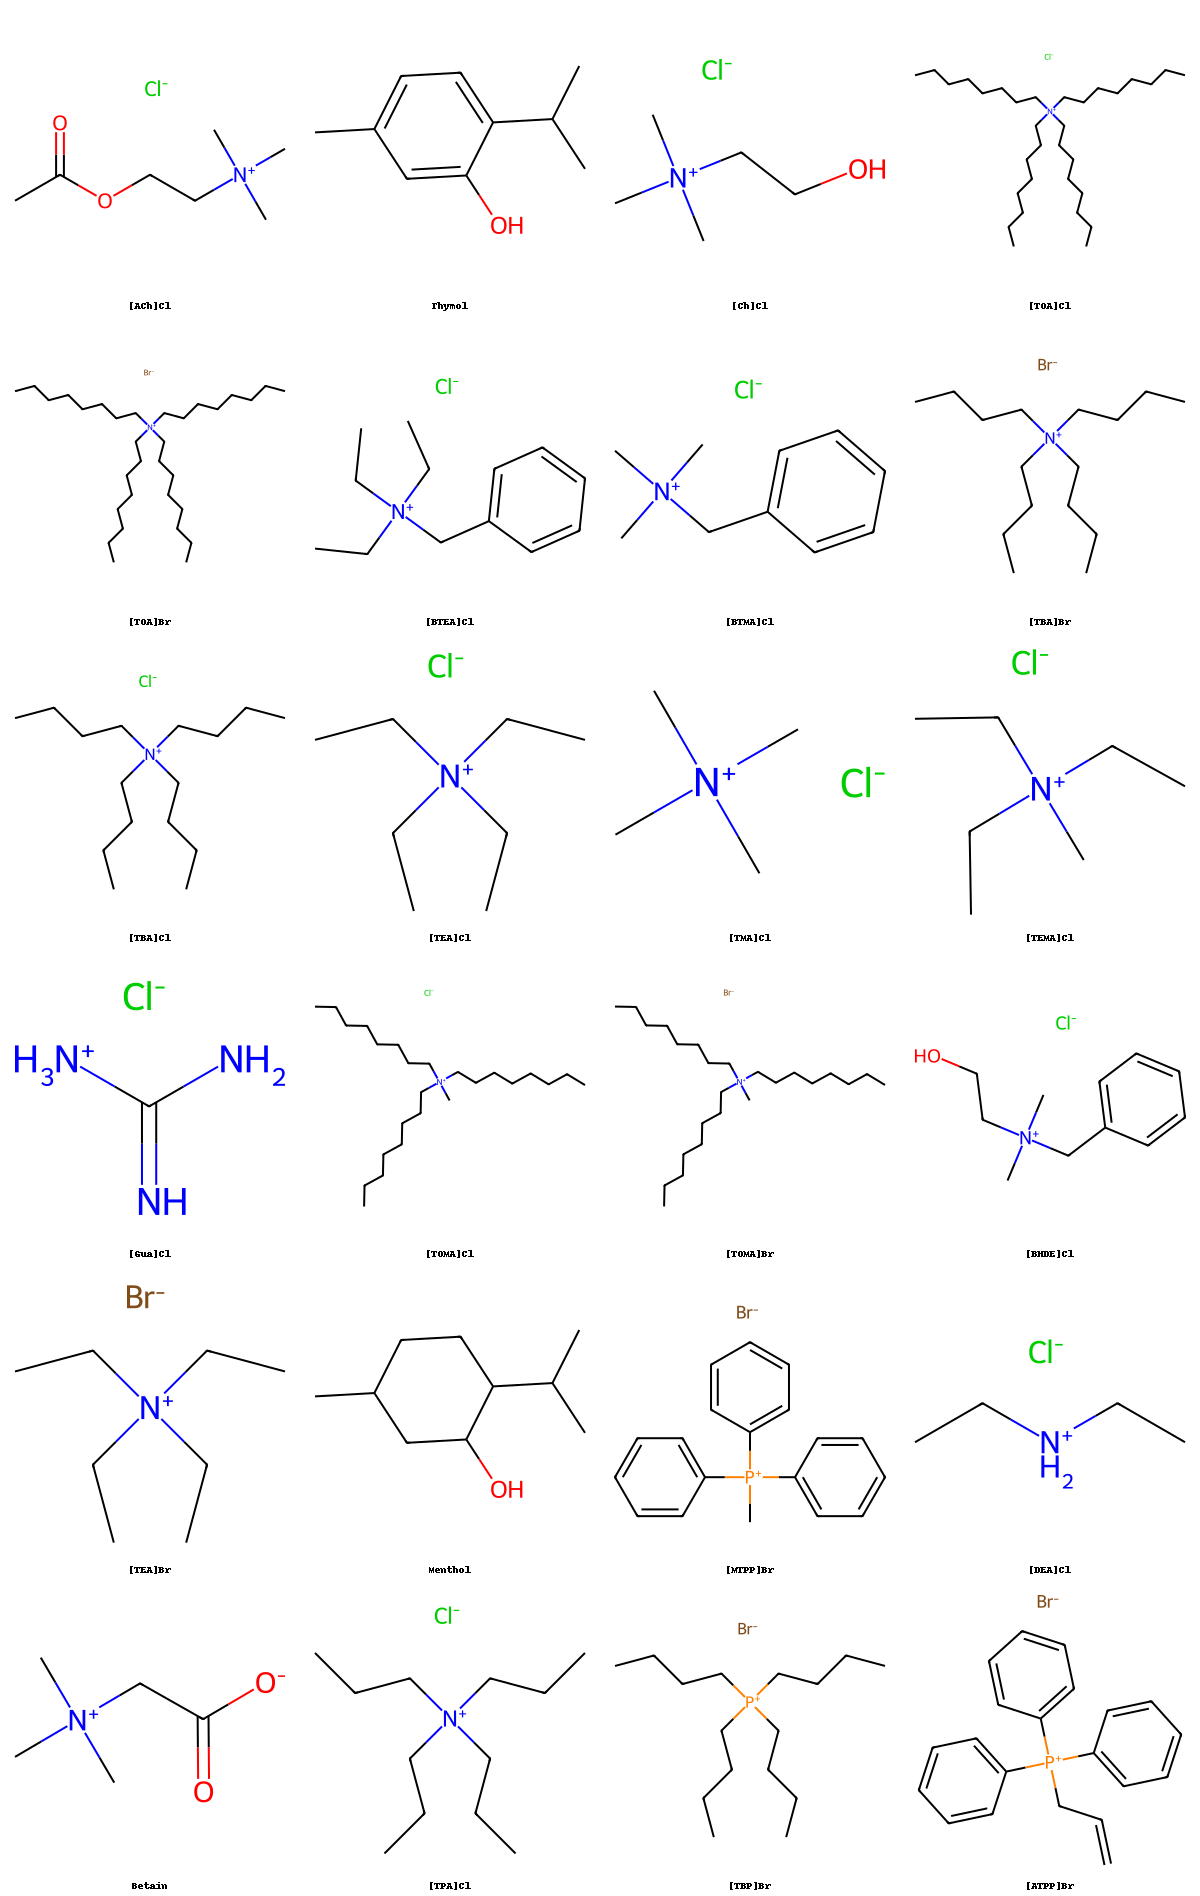

In [7]:
smiles_to_grid_image(df_hba['SMILES'].tolist(), df_hba['Short'].tolist(), columns=4)

We can see that every HBA structure matches Fig. 1 exactly. The only exception is [MTPP]Cl which was mistakenly place in Fig. 1 instead of the correct one [MTPP]C  

In [8]:
df['HBD name'].unique()

array(['1,2,4-triazole', '2,6-xylenol', 'Urea', 'Imidazole', 'DECA', 'EG',
       'AC', 'GLY', 'Phenol', 'LA', 'LEV', 'EA', 'DEG', 'MDA', 'HEXA',
       'Thymol', 'FA', 'TEG', 'OCTA', '1,4-butanediol', '2,3-butanediol',
       '1,2-propanediol', 'Guaiacol', '1,2-butanediol', 'DEA', 'ECN'],
      dtype=object)

In [9]:
df_hbd = pd.read_csv('HBD_smiles.csv')
df_hbd.head()

,Name,Short,SMILES
0,"1,2,4-triazole","1,2,4-triazole",c1nc[nH]n1
1,"2,6-xylenol","2,6-xylenol",Cc1cccc(C)c1O
2,Urea,Urea,NC(N)=O
3,Imidazole,Imidazole,c1c[nH]cn1
4,Decanoic acid,DECA,CCCCCCCCCC(=O)O


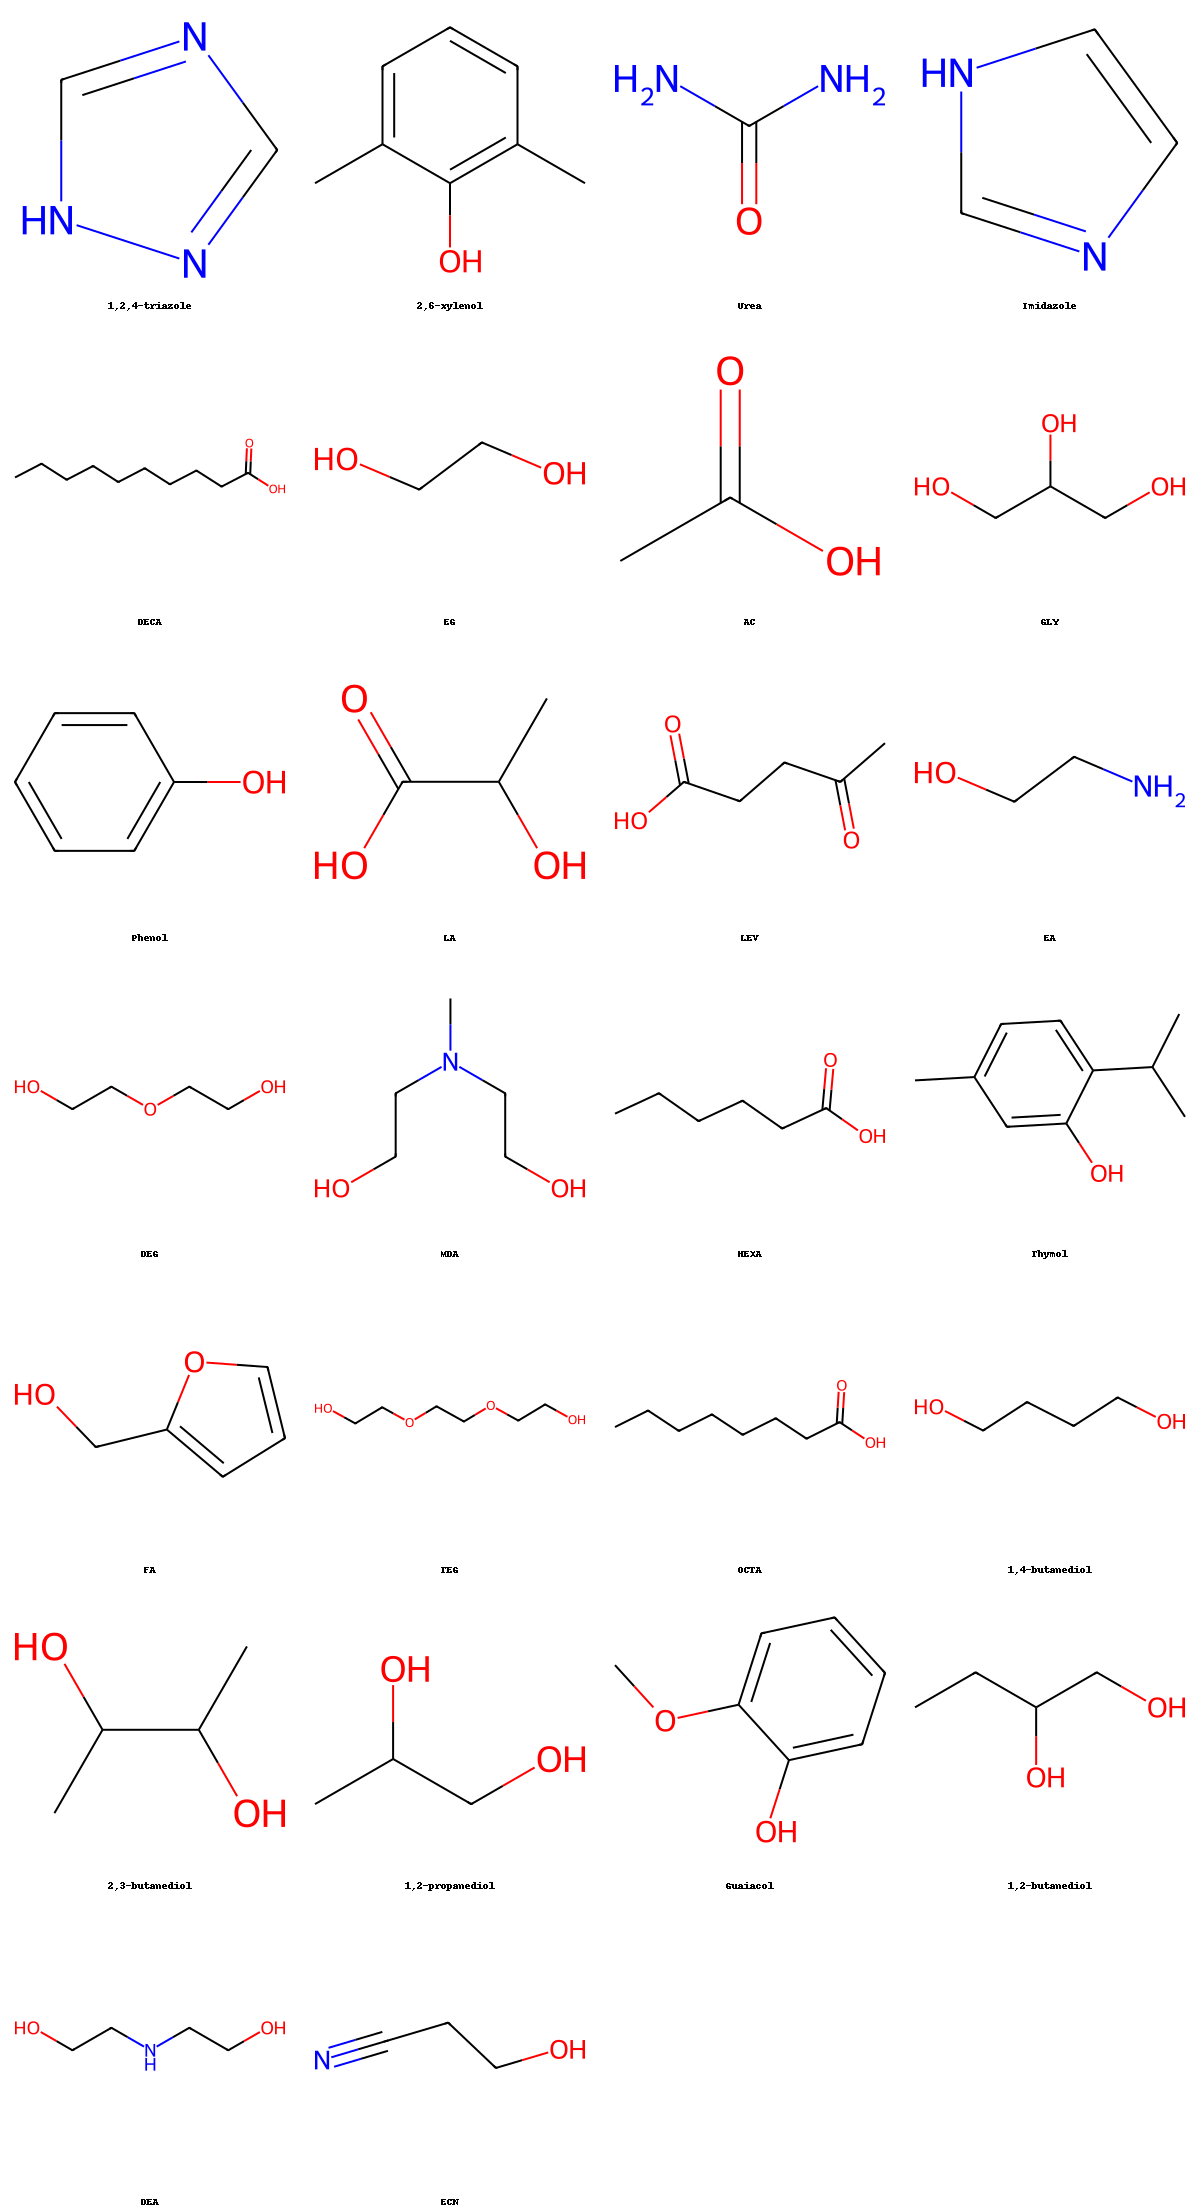

In [10]:
smiles_to_grid_image(df_hbd['SMILES'].tolist(), df_hbd['Short'].tolist(), columns=4)

In this case, all HBDs' structure match exactly Fig. 2. We have included thymol in the list of HBD as it is present as such in some systems.

## Get fingerprints

There exist two main types of molecular fingerprints: hashed and structure-based.

In [11]:
def get_fingerprint(df, type_fingerprint):
    mols = df['SMILES'].apply(Chem.MolFromSmiles).tolist()
    fgps = []

    for mol in mols:
      if type_fingerprint == 'MACCS':
        fgp = MACCSkeys.GenMACCSKeys(mol)
        fgp = np.array([int(bit) for bit in fgp.ToBitString()], dtype=int)[1:] # position 0 is always ignored
      elif type_fingerprint == 'ECFP':
        fgp = GetMorganFingerprintAsBitVect(mol, 4, 2048, bitInfo={})
      fgps.append(fgp)
    df[type_fingerprint] = fgps
    return df

### MACCS

In [12]:
df_hba = get_fingerprint(df_hba, 'MACCS')
df_hba.head()

,Name,Short,SMILES,MACCS
0,Acetylcholine chloride,[ACh]Cl,CC(=O)OCC[N+](C)(C)C.[Cl-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Thymol,Thymol,Cc1ccc(C(C)C)c(O)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Choline chloride,[Ch]Cl,C[N+](C)(C)CCO.[Cl-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Tetraoctylammonium chloride,[TOA]Cl,CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC.[Cl-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Tetraoctylammonium bromide,[TOA]Br,CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC.[Br-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
df_hbd = get_fingerprint(df_hbd, 'MACCS')
df_hbd.head()

,Name,Short,SMILES,MACCS
0,"1,2,4-triazole","1,2,4-triazole",c1nc[nH]n1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"2,6-xylenol","2,6-xylenol",Cc1cccc(C)c1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Urea,Urea,NC(N)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Imidazole,Imidazole,c1c[nH]cn1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Decanoic acid,DECA,CCCCCCCCCC(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Let's look at how the fingerprint look like for each molecule

In [14]:
def get_heatmap_fingerprints(df, type_fingerprint):
  fingerprint_df = pd.DataFrame(df[type_fingerprint].tolist())
  fingerprint_df.index = df['Short']

  plt.figure(figsize=(15, 6))
  ax = sns.heatmap(fingerprint_df, cmap='binary', cbar=False, yticklabels=True, xticklabels=True)
  plt.xlabel("MACCS key")
  plt.ylabel("Molecule")

  plt.show()

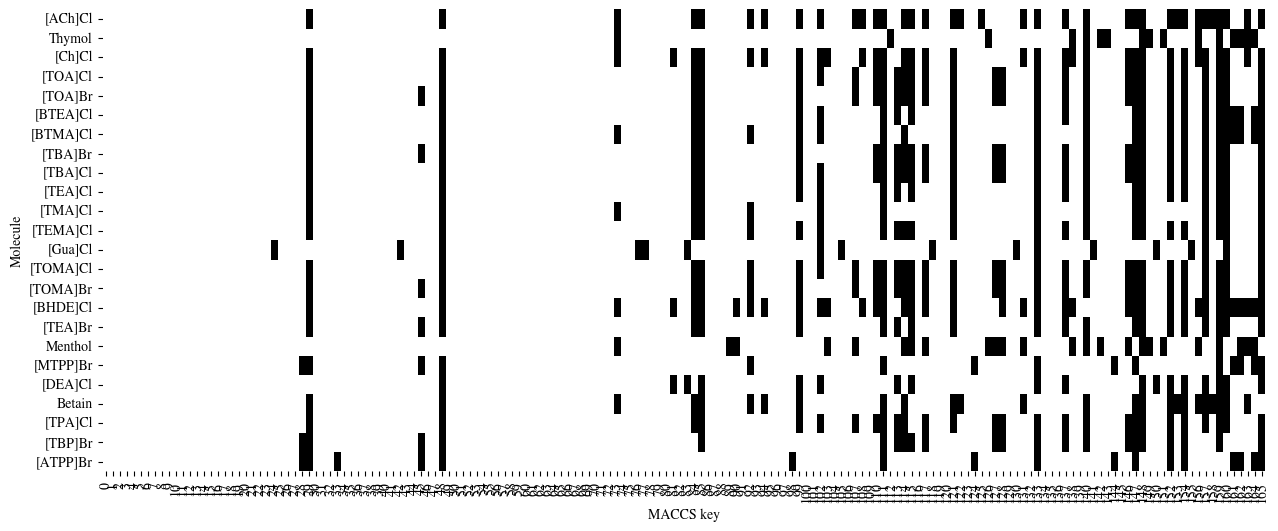

In [15]:
get_heatmap_fingerprints(df_hba, 'MACCS')

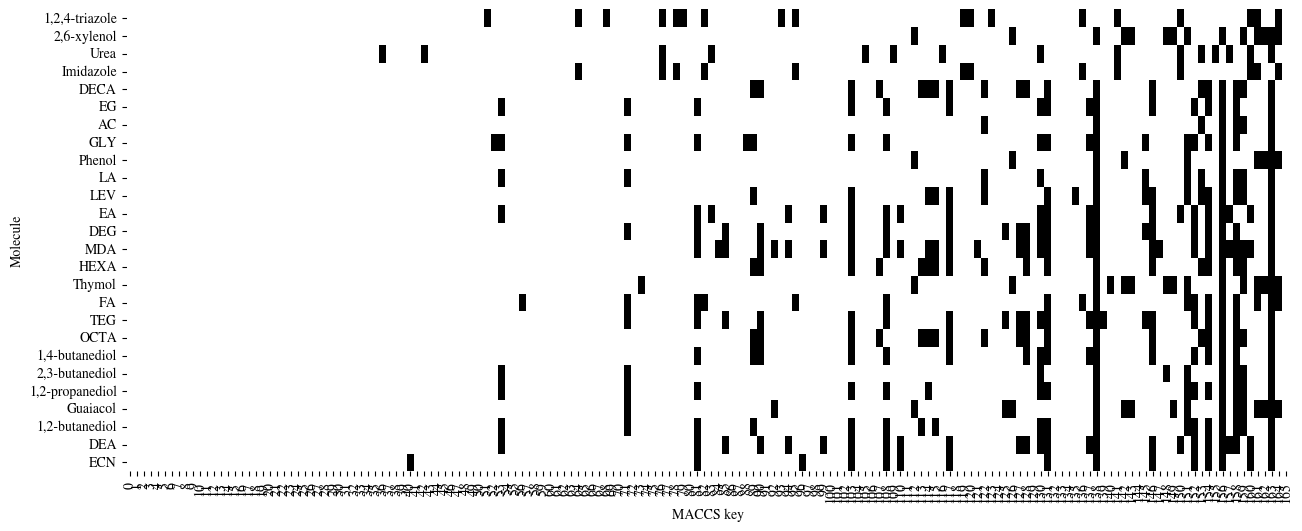

In [16]:
get_heatmap_fingerprints(df_hbd, 'MACCS')

In [17]:
df['HBA_fp'] = df['HBA name'].map(df_hba.set_index('Short')['MACCS'])
df['HBD_fp'] = df['HBD name'].map(df_hbd.set_index('Short')['MACCS'])

## Random forest

In [18]:
X_training = df[df['Split'] == 'Training'].loc[:, ['T (K)','P (kPa)','r HBA', 'r HBD']].to_numpy()

scaler = StandardScaler()
scaler.fit(X_training)

StandardScaler()

In [19]:
X_test = df[df['Split'] == 'Testing'].loc[:, ['T (K)','P (kPa)','r HBA', 'r HBD']].to_numpy()

y_train = df[df['Split'] == 'Training']['ln(x)-experimental'].to_numpy().reshape(-1,)
y_test = df[df['Split'] == 'Testing']['ln(x)-experimental'].to_numpy().reshape(-1,)

X_training_norm = scaler.transform(X_training)
X_test_norm = scaler.transform(X_test)

Let's now append the corresponding fingerprints of the HBA and HBD for each DES

In [20]:
X_training_fps = np.hstack([np.stack(df[df['Split'] == 'Training']['HBA_fp'].values),
                            np.stack(df[df['Split'] == 'Training']['HBD_fp'].values)])
X_training_fps.shape

(1085, 332)

In [21]:
X_training_norm = np.hstack([X_training_norm, X_training_fps])
X_training_norm.shape

(1085, 336)

In [22]:
X_test_fps = np.hstack([np.stack(df[df['Split'] == 'Testing']['HBA_fp'].values),
                        np.stack(df[df['Split'] == 'Testing']['HBD_fp'].values)])
X_test_fps.shape

(888, 332)

In [23]:
X_test_norm = np.hstack([X_test_norm, X_test_fps])
X_test_norm.shape

(888, 336)

In [24]:
model = RandomForestRegressor(criterion="squared_error")
model.fit(X_training_norm, y_train)

RandomForestRegressor()

In [25]:
y_hat_training, y_hat_testing = [] ,[]

for y_storage, X in zip([y_hat_training, y_hat_testing], [X_training_norm, X_test_norm]):
  y_hat = model.predict(X)
  y_storage.extend(y_hat)

In [26]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'RMSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_train = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['train']['R2'],
      metrics_dict['train']['MAPE']*100,
      metrics_dict['train']['MAE'],
      metrics_dict['train']['RMSE']**0.5))

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['RMSE']**0.5))

  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(10.0 ,5.0))

  ax1.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax1.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax1.set_ylim([-7.5,-0.5])
  ax1.set_xlim([-7.5,-0.5])
  ax1.text(-6.8,-2.5, metrics_train, fontsize=10)
  ax1.grid(visible=True,which='major',linestyle = '--' ,linewidth = 0.5)
  ax1.scatter(y_train, y_train_hat, label='Training', marker='s', color='red')
  ax1.plot(np.linspace(-7,-1), np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax1.legend(loc="best")

  ax2.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax2.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax2.set_ylim([-7.5,-0.5])
  ax2.set_xlim([-7.5,-0.5])
  ax2.text(-6.8,-2.5, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.scatter(y_test, y_test_hat, label='Testing', marker='s', color='blue')
  ax2.plot(np.linspace(-7,-1),np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax2.legend(loc="best")

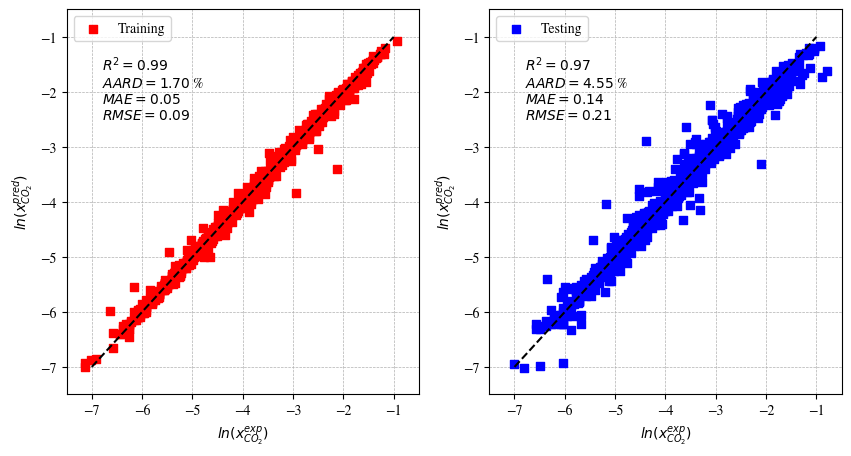

In [27]:
parity_plots(y_train, y_hat_training, y_test, y_hat_testing)

### 10-runs

In [28]:
y_train_hat_lst = []
y_test_hat_lst = []

for i in range(10):
  # Training
  model = RandomForestRegressor(criterion="squared_error")
  model.fit(X_training_norm, y_train)

  # Prediction
  y_hat_training, y_hat_testing = [] ,[]

  for y_storage, X in zip([y_hat_training, y_hat_testing], [X_training_norm, X_test_norm]):
    y_hat = model.predict(X)
    y_storage.extend(y_hat)

  # Store predictions
  y_train_hat_lst.append(y_hat_training)
  y_test_hat_lst.append(y_hat_testing)

In [29]:
def MAPE(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred)*100

metrics = [r2_score, MAPE, mean_absolute_error, mean_squared_error]

def compute_metrics(y_true, y_pred_list, metrics):
    results = {}
    for metric in metrics:
        metric_name = metric.__name__
        scores = [metric(y_true, y_pred) for y_pred in y_pred_list]
        results[metric_name] = {'mean': np.round(np.mean(scores), 2), 'std': np.round(np.std(scores),3)}
    return results

# Compute metrics for training and testing predictions
train_metrics = compute_metrics(y_train, y_train_hat_lst, metrics)
test_metrics = compute_metrics(y_test, y_test_hat_lst, metrics)

In [30]:
train_metrics

{'r2_score': {'mean': 1.0, 'std': 0.0},
 'MAPE': {'mean': 1.68, 'std': 0.019},
 'mean_absolute_error': {'mean': 0.05, 'std': 0.001},
 'mean_squared_error': {'mean': 0.01, 'std': 0.0}}

In [31]:
test_metrics

{'r2_score': {'mean': 0.97, 'std': 0.0},
 'MAPE': {'mean': 4.55, 'std': 0.035},
 'mean_absolute_error': {'mean': 0.14, 'std': 0.001},
 'mean_squared_error': {'mean': 0.04, 'std': 0.001}}

## SHAP explanations

In [32]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_norm)

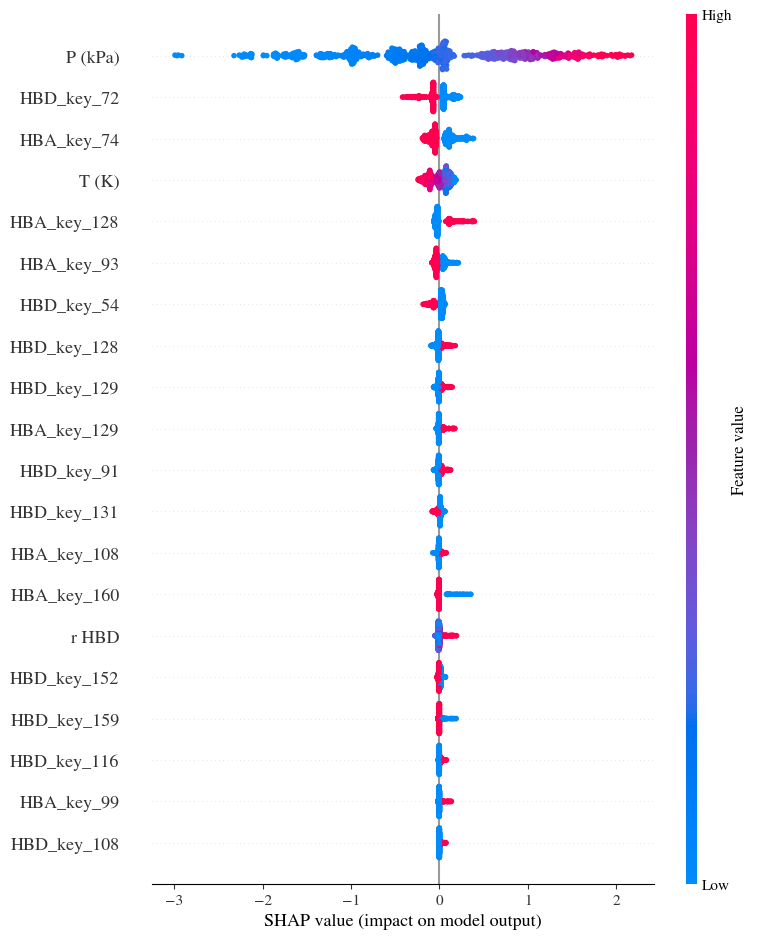

In [33]:
feature_names = ['T (K)','P (kPa)','r HBA', 'r HBD'] + ['HBA_key_'+ str(i) for i in range(1,167)] + ['HBD_key_'+ str(i) for i in range(1,167)]
shap.summary_plot(shap_values, X_test_norm, feature_names=feature_names )

Let's now look at the most important fragments according to SHAP

In [34]:
hba_maccs_key = 74
hbd_maccs_key = 72

mask = (df['HBA_fp'].apply(lambda x: x[hba_maccs_key - 1] == 1) & df['HBD_fp'].apply(lambda x: x[hbd_maccs_key - 1] == 1))
sub_df = df[mask]

relevant_DESs_lst = sub_df['DES standarized name'].unique().tolist()

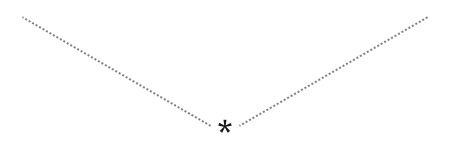

In [35]:
maccs_key = 74
Chem.MolFromSmarts(MACCSkeys.smartsPatts[maccs_key][0])

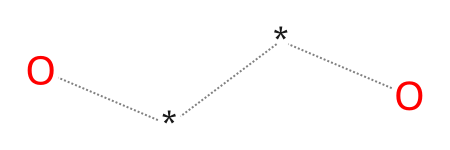

In [36]:
maccs_key = 72
Chem.MolFromSmarts(MACCSkeys.smartsPatts[maccs_key][0])


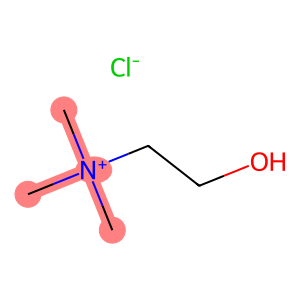
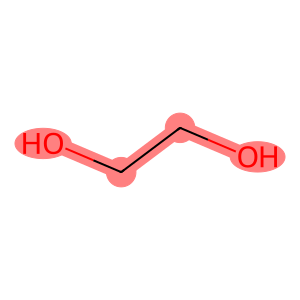

======================================== [Ch]Cl EG 1.0 2.0



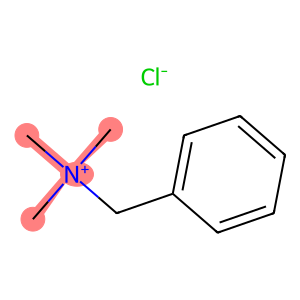
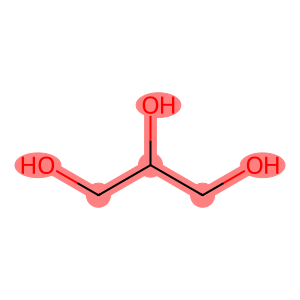

======================================== [BTMA]Cl GLY 1.0 2.0



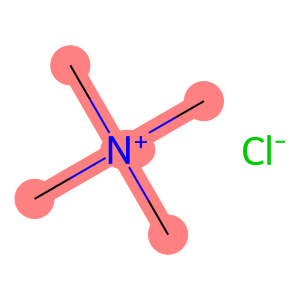
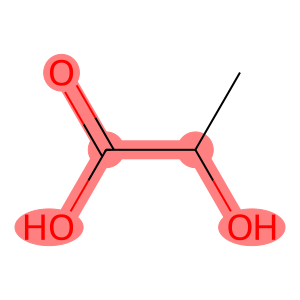

======================================== [TMA]Cl LA 1.0 2.0



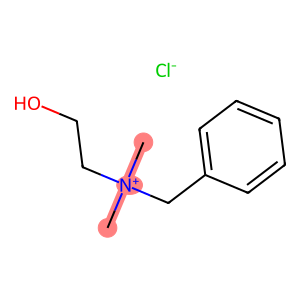
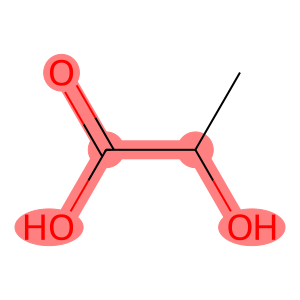

======================================== [BHDE]Cl LA 1.0 2.0



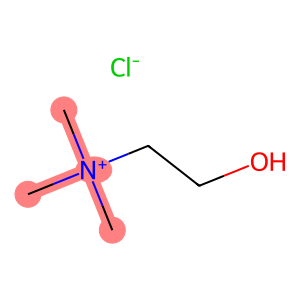
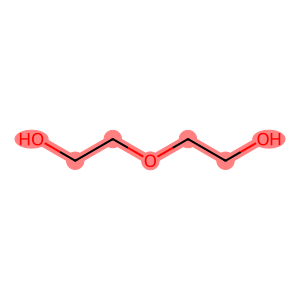

======================================== [Ch]Cl DEG 1.0 3.0



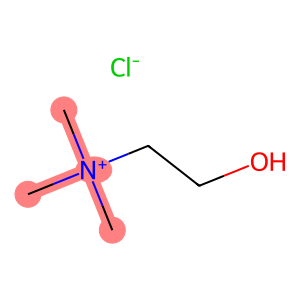
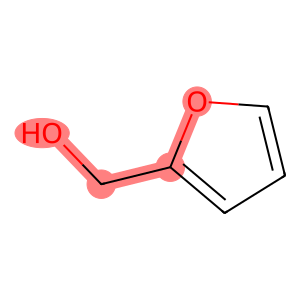

======================================== [Ch]Cl FA 1.0 3.0



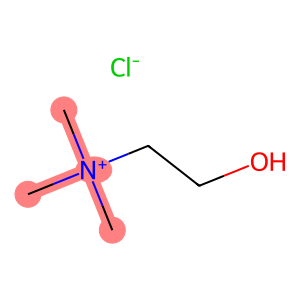
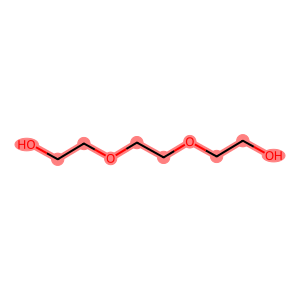

======================================== [Ch]Cl TEG 1.0 3.0



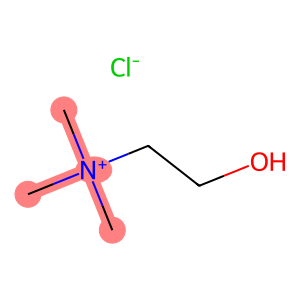
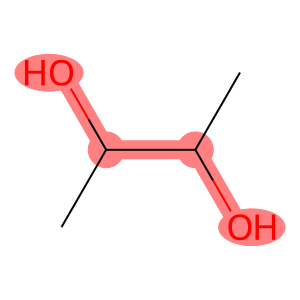

======================================== [Ch]Cl 2,3-butanediol 1.0 3.0



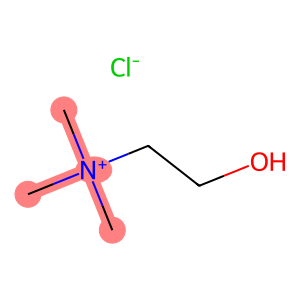
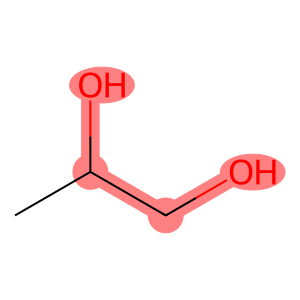

======================================== [Ch]Cl 1,2-propanediol 1.0 3.0



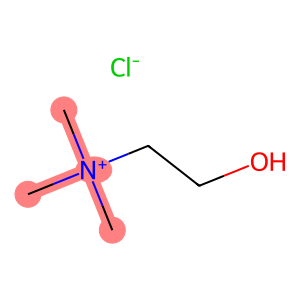
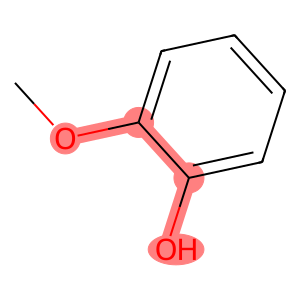

======================================== [Ch]Cl Guaiacol 1.0 3.0



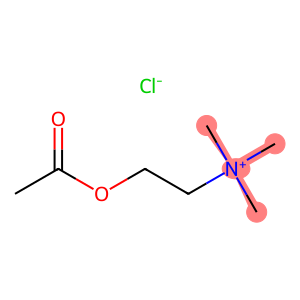
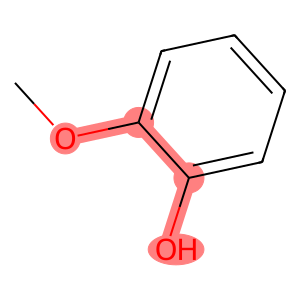

======================================== [ACh]Cl Guaiacol 1.0 3.0



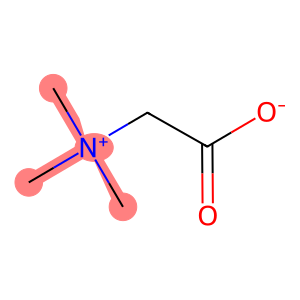
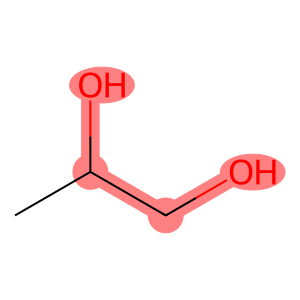

======================================== Betain 1,2-propanediol 1.0 3.5



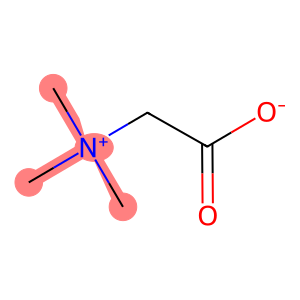
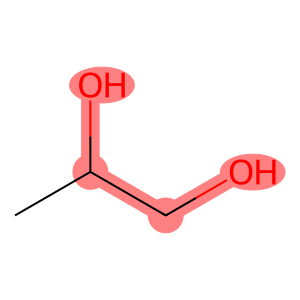

======================================== Betain 1,2-propanediol 1.0 4.0



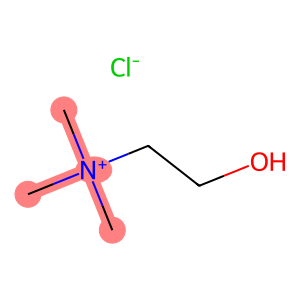
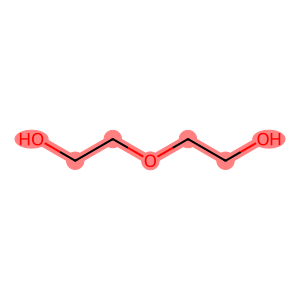

======================================== [Ch]Cl DEG 1.0 4.0



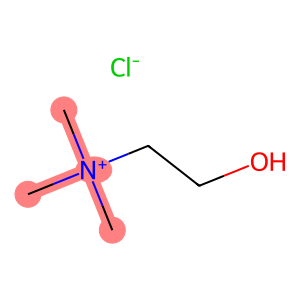
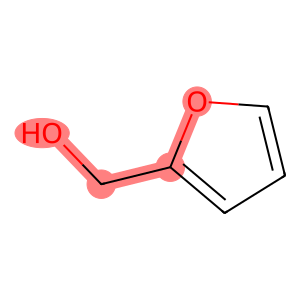

======================================== [Ch]Cl FA 1.0 4.0



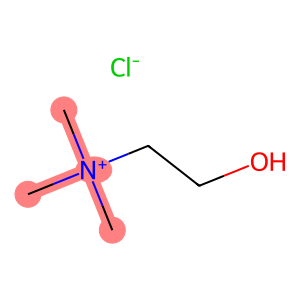
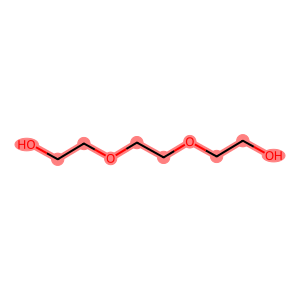

======================================== [Ch]Cl TEG 1.0 4.0



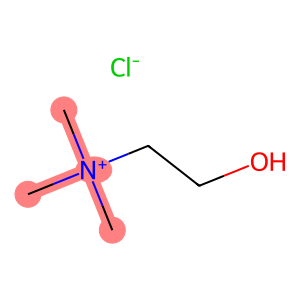
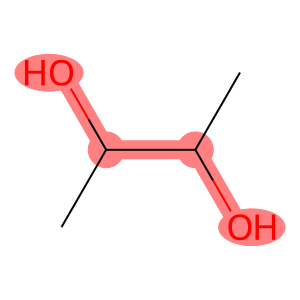

======================================== [Ch]Cl 2,3-butanediol 1.0 4.0



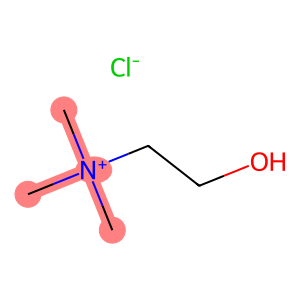
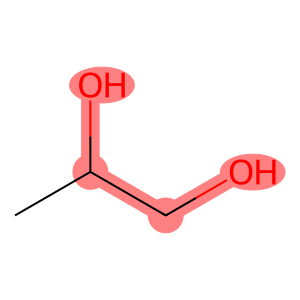

======================================== [Ch]Cl 1,2-propanediol 1.0 4.0



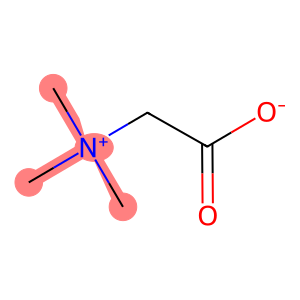
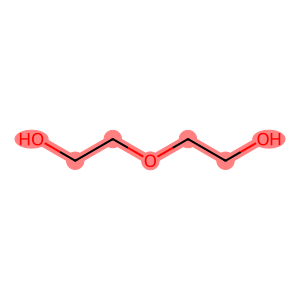

======================================== Betain DEG 1.0 4.0



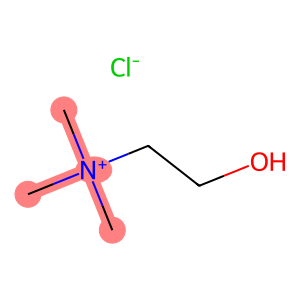
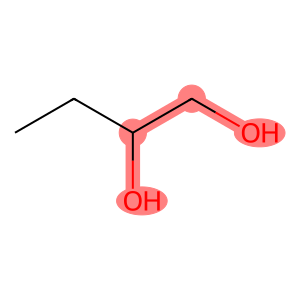

======================================== [Ch]Cl 1,2-butanediol 1.0 4.0



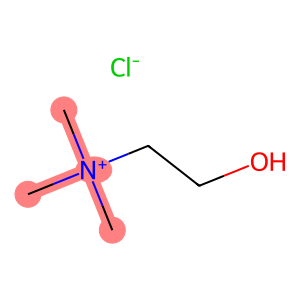
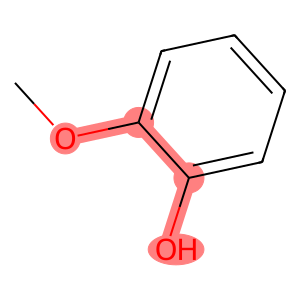

======================================== [Ch]Cl Guaiacol 1.0 4.0



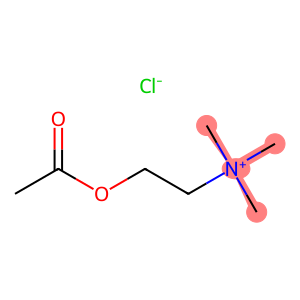
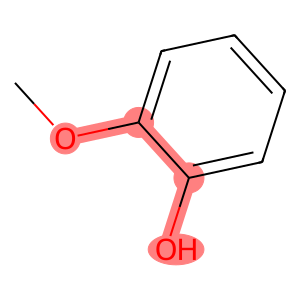

======================================== [ACh]Cl Guaiacol 1.0 4.0



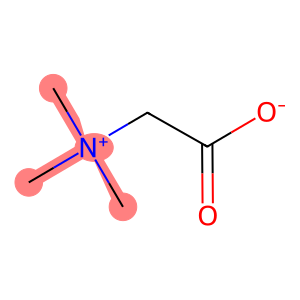
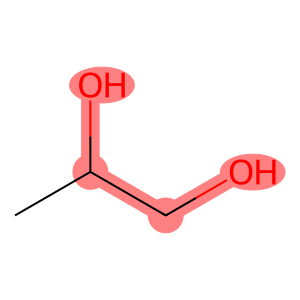

======================================== Betain 1,2-propanediol 1.0 5.0



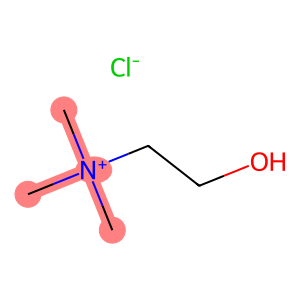
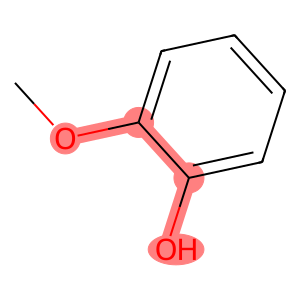

======================================== [Ch]Cl Guaiacol 1.0 5.0



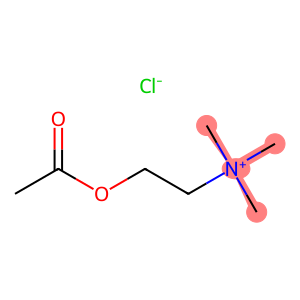
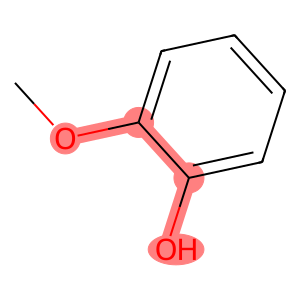

======================================== [ACh]Cl Guaiacol 1.0 5.0



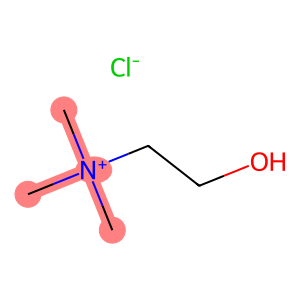
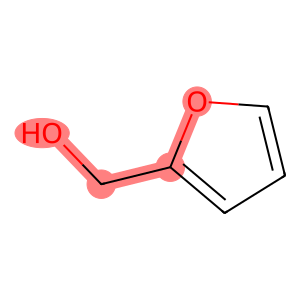

======================================== [Ch]Cl FA 1.0 5.0



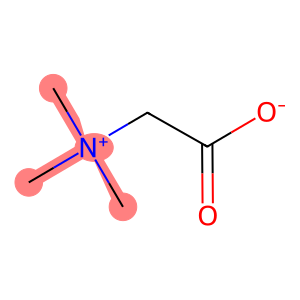
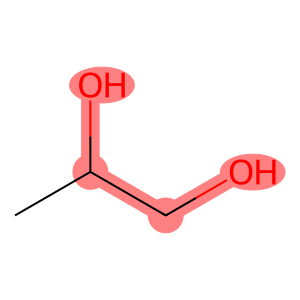

======================================== Betain 1,2-propanediol 1.0 6.0



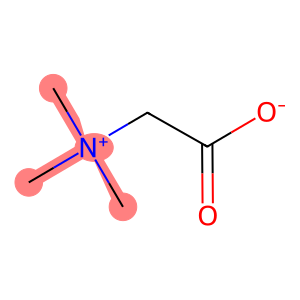
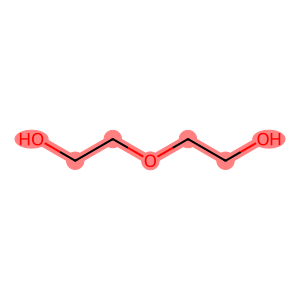

======================================== Betain DEG 1.0 6.0


In [37]:
for DES in relevant_DESs_lst:
  hba, hbd, r_hba, r_hbd = DES.split('_')

  hba_smiles = df_hba[df_hba['Short'] == hba]['SMILES'].values[0]
  hbd_smiles = df_hbd[df_hbd['Short'] == hbd]['SMILES'].values[0]

  hba_mol = Chem.MolFromSmiles(hba_smiles)
  hbd_mol = Chem.MolFromSmiles(hbd_smiles)

  # HBA substructure
  smarts = MACCSkeys.smartsPatts[hba_maccs_key][0]
  substructure_matches = hba_mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))

  highlight_atoms = [atom for match in substructure_matches for atom in match]
  highlight_bonds = []
  for atom_idx in highlight_atoms:
      atom = hba_mol.GetAtomWithIdx(atom_idx)
      for neighbor in atom.GetNeighbors():
          neighbor_idx = neighbor.GetIdx()
          if neighbor_idx in highlight_atoms:
              bond = hba_mol.GetBondBetweenAtoms(atom_idx, neighbor_idx)
              if bond:
                  highlight_bonds.append(bond.GetIdx())

  img_hba = Draw.MolToImage(hba_mol, highlightAtoms=highlight_atoms, highlightBonds=highlight_bonds)

  # HBD substructure
  smarts = MACCSkeys.smartsPatts[hbd_maccs_key][0]
  substructure_matches = hbd_mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))

  highlight_atoms = [atom for match in substructure_matches for atom in match]
  highlight_bonds = []
  for atom_idx in highlight_atoms:
      atom = hbd_mol.GetAtomWithIdx(atom_idx)
      for neighbor in atom.GetNeighbors():
          neighbor_idx = neighbor.GetIdx()
          if neighbor_idx in highlight_atoms:
              bond = hbd_mol.GetBondBetweenAtoms(atom_idx, neighbor_idx)
              if bond:
                  highlight_bonds.append(bond.GetIdx())
  img_hbd = Draw.MolToImage(hbd_mol, highlightAtoms=highlight_atoms, highlightBonds=highlight_bonds)

  # Display images side by side
  # Function to convert PIL image to data URI
  def img_to_data_uri(img):
      import base64
      from io import BytesIO
      buffered = BytesIO()
      img.save(buffered, format="PNG")
      img_str = base64.b64encode(buffered.getvalue()).decode()
      return f"data:image/png;base64,{img_str}"

  # Prepare HTML content with images side by side
  html = f'<img src="{img_to_data_uri(img_hba)}" style="display:inline-block; margin-right:10px"/>'
  html += f'<img src="{img_to_data_uri(img_hbd)}" style="display:inline-block"/>'

  # Display images
  display(HTML(html))

  print('='*40, hba, hbd, r_hba, r_hbd)